## Simulations of two-phase model for Eulerian nonlinear elasticity and diffusion material

Load the simulation from the "fout" folder and analyse the evolution of the fluid content, the fluid velocity field, the determinant of the solid deformation gradient and the energetics of the system. 

output01/solution0
time: 0.0
output01/solution10
time: 0.11250099999999999
output01/solution30
time: 0.3625010000000002
output01/solution60
time: 0.7375009999999994


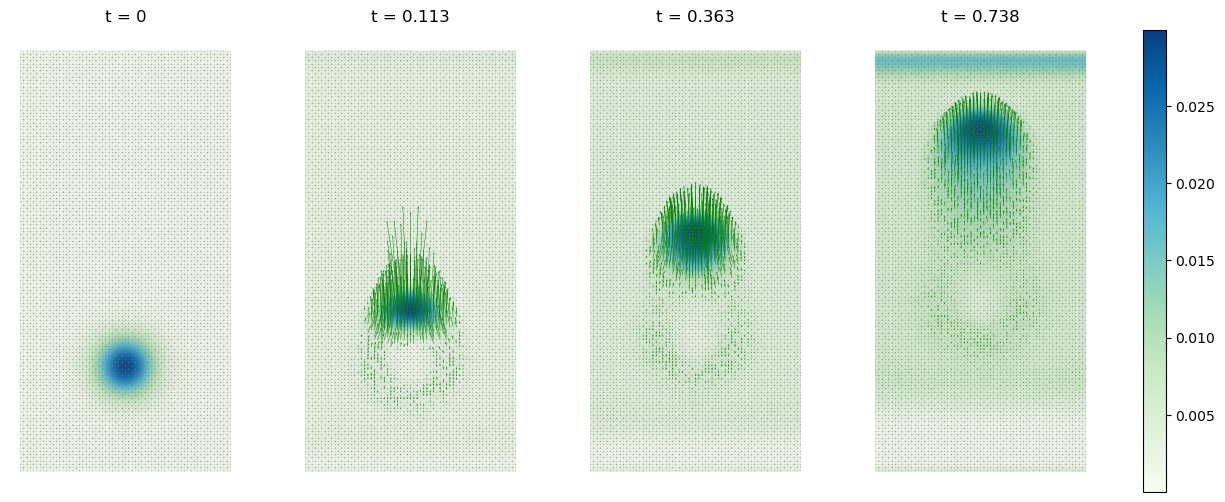

In [9]:
from fenics import *
import numpy as np
from pylab import plt
import os
from utilities import *

fout = 'output01/'

time_indices = [0, 10, 30, 60]  # You can extend this list

""" 
    Visualises a two-dimensional vector field

    Args: 
        u: a vector-valued finite element function defined on a 2D domain
        nfrac: fraction of mesh points used for plotting
        **args: arbitrary additional quiver-plot customisation parameter

    Returns: 
        Produces a vector plot on the current Matplotlib axes
"""
def plot_vec(u, nfrac=1.0, **args):
    mesh = u.function_space().mesh()
    assert u.geometric_dimension() == 2
    assert 0 < nfrac <= 1.0

    x, y, uval, vval = [], [], [], []
    for xy in mesh.coordinates():
        if np.random.rand() <= nfrac:
            val = u(Point(xy))
            x.append(xy[0]); y.append(xy[1])
            uval.append(val[0]); vval.append(val[1])

    plt.quiver(x, y, uval, vval, **args)

# --------------------------------------------
# Set up finite element types and parameters
# --------------------------------------------
FEvec  = VectorElement("CG", triangle, 1)  # Function space for solid alpha
FEscal = FiniteElement("CG", triangle, 1)  # Function space for Lagrange multiplier
FE     = MixedElement([FEvec, FEvec, FEscal, FEscal])

# --------------------------------------------
# Containers for data
# --------------------------------------------
meshes    = []
fluid_content  = []
fvelocity = []
times     = []

# --------------------------------------------
# Load data from saved simulation state
# --------------------------------------------
for i in time_indices:
    filename = fout + f"solution{i}"
    print(filename)
    mesh, q, _, t = read_state(filename, FE)
    us, uf, zeta, mu = split(q)
    print('time:', t)
    
    Vvec = FunctionSpace(mesh, FEvec)
    Vsca = FunctionSpace(mesh, FEscal)
    
    uf_cur   = project(uf, Vvec)
    zeta_cur = project(zeta, Vsca)

    # default fluid velocity (for i == 0)
    vf_proj = project(Constant((0.0, 0.0)), Vvec)
    
    # compute fluid velocity if previous step exists
    if i > 0:
        # --- read the immediate previous step i-1 ---
        fname_prev = fout + f"solution{i-1}"
        mesh_p, q_p, _, t_p = read_state(fname_prev, FE)
        us_p, uf_p, zeta_p, mu_p = split(q_p)

        # bring previous fields onto the CURRENT mesh space
        uf_prev = Function(Vvec)
        try:
            uf_prev.interpolate(uf_p)
        except Exception:
            uf_prev.assign(project(uf_p, Vvec))

        # time step between i-1 and i
        tau = Constant(t - t_p)  

        # --- fluid velocity: v_f = F_f * dot{u_f} ---
        I      = Identity(2)
        dot_uf = project((uf_cur - uf_prev) / tau, Vvec)
        Ff     = inv(I - grad(uf_cur))
        vf_expr = Ff * dot_uf
        vf_proj = project(vf_expr, Vvec)
       
    meshes.append(mesh)
    fluid_content.append(zeta_cur)
    fvelocity.append(vf_proj)
    times.append(t)  

# --------------------------------------------
# Plot zeta with v_f vectors overlaid; one colorbar
# --------------------------------------------
fig1 = plt.figure(figsize=(10*1.5, len(time_indices)*1.5))
axes = []  # keep axes for a single shared colorbar
last_mappable = None

for i, step in enumerate(time_indices):
    ax = plt.subplot(1, len(time_indices), i+1)
    axes.append(ax)

    # fluid content color plot
    zeta_plot = plot(fluid_content[i], mode='color', cmap='GnBu')
    last_mappable = zeta_plot  # save last for shared colorbar

    # mesh outline
    plot(meshes[i], linewidth=0.1)

    # overlay vector field
    plot_vec(fvelocity[i], nfrac=.5, color='green',
             angles='xy', scale_units='xy', scale=5, width=0.002)

    # title with t
    plt.title(f"t = {times[i]:.3g}")
    ax.set_axis_off()

# single shared colorbar for all zeta panels
fig1.colorbar(last_mappable, ax=axes, fraction=0.02, pad=0.04)
outname = os.path.join(fout, "zeta_with_vf.png")
fig1.savefig(outname, dpi=300)


Reading: output01/solution0
time: 0.0
Reading: output01/solution10
time: 0.11250099999999999
Reading: output01/solution30
time: 0.3625010000000002
Reading: output01/solution60
time: 0.7375009999999994


/home/andrea/miniconda3/envs/fenics-2019/lib/python3.10/site-packages/ffc/jitcompiler.py:234: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()
/home/andrea/miniconda3/envs/fenics-2019/lib/python3.10/site-packages/ffc/jitcompiler.py:234: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()
/home/andrea/miniconda3/envs/fenics-2019/l

Saved: output01/Js_panels.png


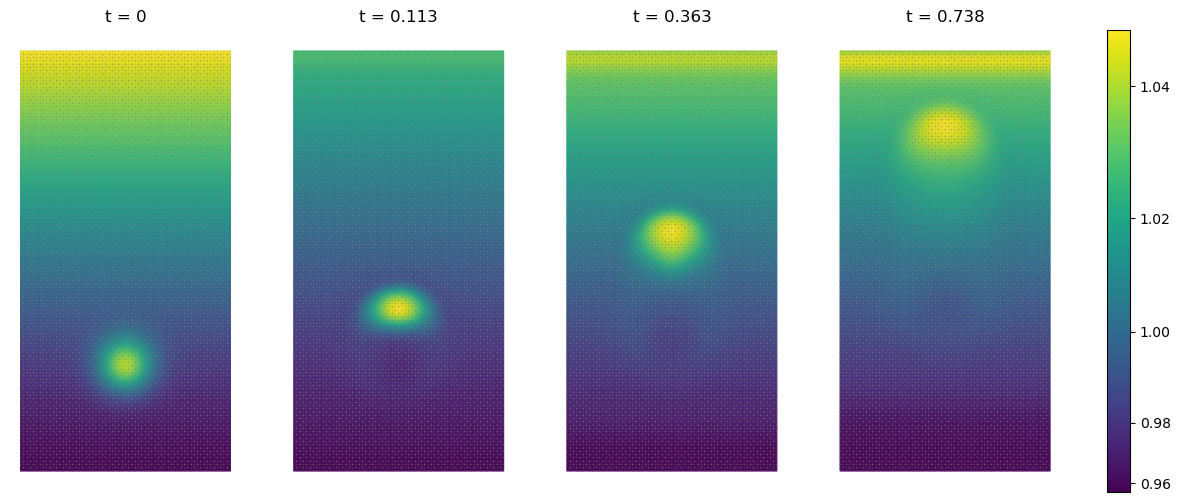

In [6]:
from fenics import *
from pylab import plt
import os
from matplotlib.colors import PowerNorm
from utilities import *

fout = 'output01/'
time_indices = [0,10,30,60]        # time steps chosen for plotting

# What to plot
draw_mesh_outline = True # Set it to False for plotting without underlying mesh

# -------------------------------
# FE types
# -------------------------------
dim = 2
FEvec  = VectorElement("CG", triangle, 1)  # us, uf
FEscal = FiniteElement("CG", triangle, 1)  # zeta, mu
FE     = MixedElement([FEvec, FEvec, FEscal, FEscal])

# -------------------------------
# Containers
# -------------------------------
meshes, sdisplacements, times = [], [], []

# -------------------------------
# Load states
# -------------------------------
for i in time_indices:
    filename = fout + f"solution{i}"
    print("Reading:", filename)
    mesh, q, _, t = read_state(filename, FE)
    us, uf, zeta, mu = split(q)

    meshes.append(mesh)
    sdisplacements.append(us)
    times.append(t)
    print('time:', t)

# -------------------------------
# Plot: determinant of solid deformation Js
# Fs = inv(I - grad(us)), Js = det(Fs)
# -------------------------------

ffc_params = {"representation": "quadrature", "quadrature_degree": 4}
fig_Js = plt.figure(figsize=(10*1.5, len(time_indices)*1.5))
axes_Js = []
last_map = None
for i, step in enumerate(time_indices):
    ax = plt.subplot(1, len(time_indices), i+1)
    axes_Js.append(ax)
    mesh = Mesh(meshes[i])
    Vscal = FunctionSpace(mesh, "CG", 1)
    I = Identity(dim)
    Fs = inv(I - grad(sdisplacements[i]))
    Js = det(Fs)
    # project Js to CG1 for plotting
    Js_proj = project(Js, Vscal,
                      form_compiler_parameters=ffc_params)
    # color plot
    p = plot(Js_proj, mode='color', norm=PowerNorm(gamma=1.5))
    last_map = p
    if draw_mesh_outline:
        plot(mesh, linewidth=0.1)
    ax.set_axis_off()
    ax.set_title(f"t = {times[i]:.3g}")
fig_Js.subplots_adjust(wspace=1e-8, hspace=0.01)
# one shared colorbar
fig_Js.colorbar(last_map, ax=axes_Js,
                fraction=0.02, pad=0.04)
outname = os.path.join(fout, "Js_panels.png")
fig_Js.savefig(outname, dpi=300)
print("Saved:", outname)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Saved: output01/energy_and_dissipation_vs_time.png


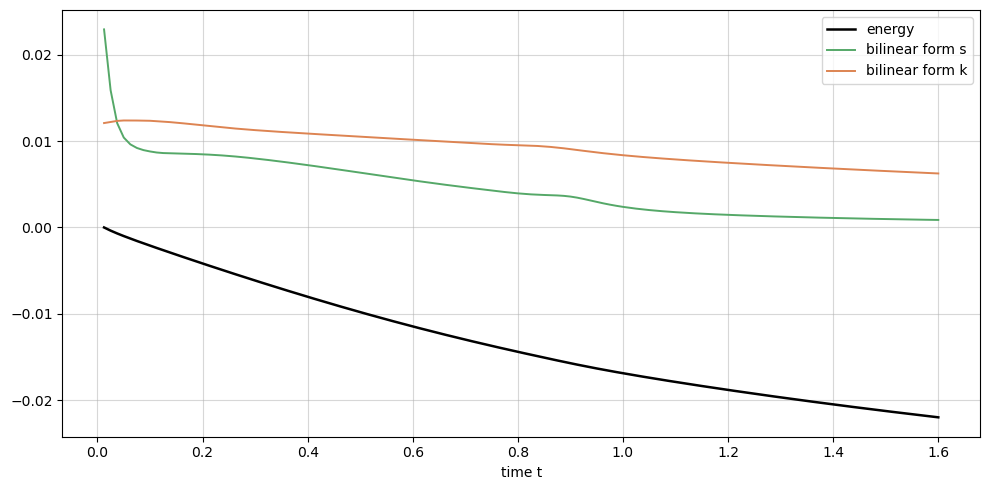

In [5]:
from fenics import *
import numpy as np
from pylab import plt
import os
from utilities import *
import re

# Setting the folder where solutions are
fout = 'output01/'

use_all_steps = False
time_indices = np.arange(1, 130) # only use if use_all_steps is set to False. 

ffc_params = {"quadrature_degree": 4}

# -------------------------------
# Discover steps
# detects "solution" files in the fout folder.
# -------------------------------
def discover_steps(folder):
    steps = set()
    for name in os.listdir(folder):
        m = re.match(r'^solution(\d+)', name)
        if m:
            steps.add(int(m.group(1)))
    return sorted(steps)

steps = discover_steps(fout) if use_all_steps else sorted(time_indices)
if not steps:
    raise RuntimeError("No 'solution*' files found in folder: " + fout)

# -------------------------------
# Storage
# -------------------------------
times, Hvals, Evals = [], [], []
Dmech, Ddiff = [], []

# -------------------------------
# Definition of energy functional
# -------------------------------
def get_energy(mesh, us, uf, zeta, params):
    d = 2
    x = SpatialCoordinate(mesh)
    I = Identity(d)

    Fs = inv(I - grad(us))
    Js = det(Fs)

    rho_s = params['rho_s']
    E     = params['E']
    G     = params['G']
    z0    = params['z0']
    eps1  = params['eps1_hat']
    eps2  = params['eps2_hat']

    Cs = Fs.T*Fs / Js
    Hs = E/2*(tr(Cs - I))

    p    = (zeta - z0) - (Js - 1)
    Hmix = G*(p**2)/2

    g   = as_vector((0.0, 1))
    Hgr = inner(zeta*g, x) + inner(rho_s/Js*g, x)

    Hreg = (eps1/2)*inner(grad(zeta), grad(zeta)) \
         + eps2*zeta*(ln(zeta/z0) - 1)

    return (Hs + Hmix + Hgr + Hreg)*dx

# -------------------------------
# Definition of dissipative bilinear forms
# -------------------------------
def s(old_zeta, dot_us, dot_uf, params, us_midF, uf_midF):
    I = Identity(2)

    Fs_mid = inv(I - grad(us_midF))
    Ff_mid = inv(I - grad(uf_midF))

    vs_mid = Fs_mid * dot_us
    vf_mid = Ff_mid * dot_uf

    vs_hat = vs_mid
    vf_hat = vf_mid

    Lambda = params['Lambda']
    Ss     = params['Ss']
    Sf     = params['Sf']
    z0     = params['z0']

    s_darcy   = (Lambda*(z0/old_zeta)**2) * inner(-vs_hat + vf_hat,
                                                  -vs_hat + vf_hat)
    ss_stokes = Ss * inner(grad(vs_hat), grad(vs_hat))
    sf_stokes = Sf * inner(grad(vf_hat), grad(vf_hat))

    return (s_darcy + ss_stokes + sf_stokes)*dx

def a(old_zeta, muz, params):
    Pe = params['Pe']
    return (1.0/Pe)*old_zeta*inner(grad(muz), grad(muz))*dx

# -------------------------------
# Read parameters
# -------------------------------
pars = read_dictionary(fout + 'parameters.json')

# -------------------------------
# Read first state
# -------------------------------
fname0 = os.path.join(fout, f"solution{steps[0]}")
mesh0, q0, _, t0 = read_state_mesh(fname0, None)
V = get_space(mesh0)

us0, uf0, zeta0, mu0 = q0.split(deepcopy=True)
prev_data = (mesh0, us0, uf0, zeta0, mu0, t0)

def nodal_fd(newF, oldF, dt, V):
    """
    Compute a nodal finite-difference time derivative of a finite element function.

    Args:
        newF : Finite element function at the current time level t^n.
        oldF : Finite element function at the previous time level t^{n-1}.
        dt   : Time step size (t^n - t^{n-1}).
        V    : Function space in which the output derivative is represented.

    Returns:
        A finite element function in V whose nodal values approximate
        (newF - oldF) / dt.
    """
    out = Function(V)
    out.vector()[:] = (newF.vector() - oldF.vector())/dt
    return out

# -------------------------------
# Time loop
# -------------------------------
for k, n in enumerate(steps):
    fname = os.path.join(fout, f"solution{n}")
    _, q, _, t = read_state_mesh(fname, V)
    us, uf, zeta, muz = q.split(deepcopy=True)

    if k == 0:
        prev_data = (mesh0, us, uf, zeta, muz, t)
        continue

    mesh_0, us_pF, uf_pF, zeta_pF, mu_pF, t_p = prev_data
    dt = t - t_p

    Vus = V.sub(0).collapse()
    Vuf = V.sub(1).collapse()

    us_midF = project(0.5*(us + us_pF), Vus)
    uf_midF = project(0.5*(uf + uf_pF), Vuf)

    dot_us = nodal_fd(us, us_pF, dt, Vus)
    dot_uf = nodal_fd(uf, uf_pF, dt, Vuf)

    prev_data = (mesh_0, us, uf, zeta, muz, t)

    Hvals.append(assemble(get_energy(mesh0, us, uf, zeta, pars)))
    Dmech.append(assemble(s(zeta_pF, dot_us, dot_uf, pars, us_midF, uf_midF)))
    Ddiff.append(assemble(a(zeta_pF, muz, pars)))
    times.append(t)

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 5))

H0 = Hvals[0]
dH = np.array(Hvals) - H0

colors = {
    "diff": "#DD8452",
    "mech": "#55A868",
}
ax.plot(times, dH, '-', lw=1.8, ms=4, color="black", label='energy')
ax.plot(times, Dmech, '-', lw=1.4, ms=4, color=colors["mech"], label='bilinear form s')
ax.plot(times, Ddiff, '-', lw=1.4, ms=4, color=colors["diff"], label='bilinear form k')

ax.set_xlabel('time t')
ax.legend()
ax.grid(True, alpha=0.5)

outplot = os.path.join(fout, "energy_and_dissipation_vs_time.png")
plt.tight_layout()
plt.savefig(outplot, dpi=300)
print("Saved:", outplot)
